# STA 141B Final Project Code
### from Colin Lauffer, Brett Loy, and Jorah Razumeyko

### import packages used

In [129]:
from bs4 import BeautifulSoup
from bs4 import Tag
import requests
import re 
import pandas as pd
import copy
import sys
import numpy as np
import time
import os
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from collections import Counter
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter #to improve plot


### Get all URLs

In [2]:
nba_teams = [
    'ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GS', 
    'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NO', 'NY', 
    'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SA', 'TOR', 'UTAH', 'WSH'
]
base_url = 'https://www.espn.com/nba/team/schedule/_/name/'
season = '2023'
team_dataframes = {}

### Scrape and load schedule data for each team 


In [94]:
for team in nba_teams:
    try:
        url = f"{base_url}{team}/season/{season}"
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        espn_response = requests.get(url, headers=headers)
        print(f"Sucess loading: {team}")
        soup = BeautifulSoup(espn_response.content, 'html.parser')
        table = soup.find_all('table')[0]
        data = []
        for row in table.find_all('tr')[1:]:
            postponed_cell = row.find('td', colspan="5")
            if postponed_cell and 'Postponed' in postponed_cell.text:
                row.decompose()  # Remove the row from the DOM
            
            cols = row.find_all('td')
            if len(cols) > 0:
                date = cols[0].text.strip()
                opponent = cols[1].text.strip()
                result = cols[2].text.strip()
                win_loss = cols[3].text.strip()
                data.append([date, opponent, result,win_loss])
            team_dataframes[team] = pd.DataFrame(data, columns=['Date', 'Opponent', 'Result', "W/L"])
        time.sleep(5)
    except Exception as e:
        print(f"Error loading page: {e}")
        time.sleep(5)

https://www.espn.com/nba/team/schedule/_/name/ATL/season/2023
Sucess loading: ATL
https://www.espn.com/nba/team/schedule/_/name/BOS/season/2023
Sucess loading: BOS
https://www.espn.com/nba/team/schedule/_/name/BKN/season/2023
Sucess loading: BKN
https://www.espn.com/nba/team/schedule/_/name/CHA/season/2023
Sucess loading: CHA
https://www.espn.com/nba/team/schedule/_/name/CHI/season/2023
Sucess loading: CHI
https://www.espn.com/nba/team/schedule/_/name/CLE/season/2023
Sucess loading: CLE
https://www.espn.com/nba/team/schedule/_/name/DAL/season/2023
Sucess loading: DAL
https://www.espn.com/nba/team/schedule/_/name/DEN/season/2023
Sucess loading: DEN
https://www.espn.com/nba/team/schedule/_/name/DET/season/2023
Sucess loading: DET
Removing row: <tr class="Table__TR Table__TR--sm Table__even" data-idx="54"><td class="Table__TD"><span>Wed, Feb 1</span></td><td class="Table__TD"><div class="flex items-center opponent-logo"><span class="pr2">vs</span><span class="tc pr2" style="width:20px;hei

### code to make sure all dates are included

In [95]:
new_start_date = pd.to_datetime('1900-10-18')
new_end_date = pd.to_datetime('1900-04-09')

### code to calculate additional variables for each team and to save as CSV for ease of sharing and to not scrape each time

In [96]:
for team, dataframe in team_dataframes.items():
    if len(dataframe) > 1:  # Check if the DataFrame has any rows
        dataframe = dataframe.iloc[1:, :]  # Remove the first row
        dataframe['Date'] = pd.to_datetime(dataframe['Date'], format="%a, %b %d")
        dataframe['PA'] = dataframe['Result'].apply(lambda x: int(re.search(r'L(\d+)-\d+', x).group(1))
                                                    if x.startswith('L') else int(re.search(r'W\d+-(\d+)', x).group(1)))
        dataframe['PF'] = dataframe['Result'].apply(lambda x: int(re.search(r'W(\d+)-\d+', x).group(1))
                                                    if x.startswith('W') else int(re.search(r'L\d+-(\d+)', x).group(1)))
        dataframe["PDiff"] = dataframe['PF'] - dataframe['PA']
        dataframe["PDiff_cumulative"] = dataframe['PDiff'].cumsum()
        
        if not (dataframe['Date'] == new_start_date).any():
            new_row_start = pd.DataFrame({'Date': [new_start_date]})
            dataframe = pd.concat([new_row_start, dataframe]).reset_index(drop=True)

        if not (dataframe['Date'] == new_end_date).any():
            new_row_end = pd.DataFrame({'Date': [new_end_date]})
            dataframe = pd.concat([dataframe, new_row_end]).reset_index(drop=True)

        if len(dataframe) > 0 and not dataframe.empty:
            for col in dataframe.columns:
                if pd.isnull(dataframe.iloc[0][col]):
                    dataframe.at[dataframe.index[0], col] = dataframe.iloc[1][col]


        # shift dates based on month to update the year
        dataframe.loc[dataframe['Date'].dt.month >= 10, 'Date'] += pd.offsets.DateOffset(years=122)
        dataframe.loc[dataframe['Date'].dt.month < 10, 'Date'] += pd.offsets.DateOffset(years=123)

        # set 'Date' as index and resample to fill missing dates
        dataframe.set_index('Date', inplace=True)
        dataframe = dataframe.resample('D').asfreq()
        dataframe = dataframe.fillna(method='ffill')

        # Save the modified DataFrame as CSV
        directory = r"C:\Statistics\STA 141B Project"
        if not os.path.exists(directory):
            os.makedirs(directory)

        csv_filename = f"{directory}/{team}_data.csv"
        dataframe.to_csv(csv_filename)

        print(f"CSV file saved for {team}")
    else:
        print(f"No data available for {team}")


C:\Users\horse\AppData\Local\Temp\ipykernel_41048\476364459.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  dataframe['Date'] = pd.to_datetime(dataframe['Date'], format="%a, %b %d")
C:\Users\horse\AppData\Local\Temp\ipykernel_41048\476364459.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Date'] = pd.to_datetime(dataframe['Date'], format="%a, %b %d")
C:\Users\horse\AppData\Local\Temp\ipykernel_41048\476364459.py

CSV file saved for ATL
CSV file saved for BOS
CSV file saved for BKN
CSV file saved for CHA
CSV file saved for CHI
CSV file saved for CLE
CSV file saved for DAL
CSV file saved for DEN
CSV file saved for DET
CSV file saved for GS
CSV file saved for HOU
CSV file saved for IND
CSV file saved for LAC
CSV file saved for LAL
CSV file saved for MEM
CSV file saved for MIA
CSV file saved for MIL
CSV file saved for MIN
CSV file saved for NO
CSV file saved for NY
CSV file saved for OKC
CSV file saved for ORL
CSV file saved for PHI
CSV file saved for PHX
CSV file saved for POR
CSV file saved for SAC
CSV file saved for SA
CSV file saved for TOR
CSV file saved for UTAH
CSV file saved for WSH


C:\Users\horse\AppData\Local\Temp\ipykernel_41048\476364459.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Date'] = pd.to_datetime(dataframe['Date'], format="%a, %b %d")
C:\Users\horse\AppData\Local\Temp\ipykernel_41048\476364459.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['PA'] = dataframe['Result'].apply(lambda x: int(re.search(r'L(\d+)-\d+', x).group(1))
C:\Users\horse\AppData\Local\Temp\ipykernel_41048\476364459.py:7: SettingWithCopyWarning: 
A value is trying to be set

### Code to scrape transactions from Basketball Reference

In [98]:
# load and save data from this url
url = "https://www.basketball-reference.com/leagues/NBA_2023_transactions.html" 

# Send a request
response = requests.get(url)

# save if successful
if response.status_code == 200:
    # Save the HTML content to a local file
    with open("basketball_reference_page.html", "w", encoding="utf-8") as file:
        file.write(response.text)
    print("HTML content saved successfully.")
else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")


HTML content saved successfully.


In [99]:
# Reading HTML content from the saved file
with open("basketball_reference_page.html", "r", encoding="utf-8") as file:
    html_content = file.read()

# save html as html
html = BeautifulSoup(html_content, "html.parser")

In [100]:
#dictionary with list of trades for corresponding day
trades_in_day = {} 
#loop to go through webpage and find days with trades 
for i in range(0,336):
    # scan to find every block for which transactions occur 
    all_days = html.find_all(["li"])
    #only include blocks on which transactions include trades
    trade_days = [li for li in all_days if "traded" in li.get_text().lower()]
    #test if i is greater than number of days with trades
    if len(trade_days) == (i):
        break
    #get date for ith transaction day
    date = trade_days[i].span.string
    
    all_transactions = trade_days[i].find_all(["p"])
    all_trades = [p for p in all_transactions if "traded" in p.get_text().lower()]
    trades_in_day[date] = all_trades
    

In [101]:
urls_for_sal = trades_in_day

# Remove data prior to the season and after the season ends
for i in list(trades_in_day.keys())[:8] + list(trades_in_day.keys())[-3:]:
    if i in urls_for_sal:
        del urls_for_sal[i]

# Convert all values to strings
urls_for_sal = {key: [str(value) for value in values] for key, values in urls_for_sal.items()}

# Combine values for each key into one long string
combined_values = {key: ', '.join(values) for key, values in urls_for_sal.items()}

# Combine all the long strings into one
final_combined_string = ', '.join(combined_values.values())


# Extract player names and URLs
player_info = re.findall(r'<a href="(/players/.*?\.html)">(.*?)</a>', final_combined_string)

# Create a dictionary with player names as keys and URLs as values
player_dict = {name: url for url, name in player_info}

# Print the player dictionary


In [102]:
player_data = {key: value for key, value in player_dict.items() if key != ''}
#player_data

### code to scrape salaries of players

In [103]:
base_url = "https://www.basketball-reference.com"
player_salaries = {}

In [104]:
for player, player_url in player_data.items():
    try:
        url = f"{base_url}{player_url}"
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        bask_response = requests.get(url, headers=headers)
        print(f"Sucess loading: {player}")
        if bask_response.status_code == 200:
            soup = BeautifulSoup(bask_response.content, 'html.parser')
            table_wrappers = soup.find_all('div', class_='table_wrapper', id="all_all_salaries")
            # Rest of your processing code...
            pattern_extract_text = r'data-stat="season" >2022-23(.*?)</tbody>'
            extracted_text = re.search(pattern_extract_text, str(table_wrappers), re.DOTALL)
            if extracted_text:
                text_between = extracted_text.group(1)
                pattern_extract_numbers_after_dollar = r'\$(\d[\d,]*)'
                numbers_after_dollar = re.findall(pattern_extract_numbers_after_dollar, text_between)
                if numbers_after_dollar:
                    player_salaries[player] = numbers_after_dollar[0]
                    print(f"Salary for {player}: {numbers_after_dollar[0]}")
                else:
                    print(f"No salary found for {player}")
                    player_salaries[player] = '0'
            else:
                print(f"Text not found for {player}")
                player_salaries[player] = '0'
            time.sleep(5)
        else:
            print(f"Failed to load {player}. Status code: {bask_response.status_code}")
            player_salaries[player] = '0'
            time.sleep(5)
    except Exception as e:
        print(f"Error loading page for {player}: {e}")
        player_salaries[player] = '0'
        time.sleep(5)
        

   
   

Sucess loading: Noah Vonleh
Salary for Noah Vonleh: 1,160,955
Sucess loading: Kendrick Nunn
Salary for Kendrick Nunn: 5,250,000
Sucess loading: Tristan Vukcevic
Text not found for Tristan Vukcevic
Sucess loading: Rui Hachimura
Salary for Rui Hachimura: 6,263,188
Sucess loading: Kyrie Irving
Salary for Kyrie Irving: 38,917,057
Sucess loading: Markieff Morris
Salary for Markieff Morris: 1,836,090
Sucess loading: Spencer Dinwiddie
Salary for Spencer Dinwiddie: 19,500,000
Sucess loading: Dorian Finney-Smith
Salary for Dorian Finney-Smith: 12,939,848
Sucess loading: Kessler Edwards
Salary for Kessler Edwards: 1,637,966
Sucess loading: David Michineau
Text not found for David Michineau
Sucess loading: Dewayne Dedmon
Salary for Dewayne Dedmon: 4,700,000
Sucess loading: Mason Plumlee
Salary for Mason Plumlee: 9,080,417
Sucess loading: Reggie Jackson
Salary for Reggie Jackson: 10,876,844
Sucess loading: Jalen McDaniels
Salary for Jalen McDaniels: 1,930,681
Sucess loading: Cam Spencer
Text not f

In [105]:
player_salaries

{'Noah Vonleh': '1,160,955',
 'Kendrick Nunn': '5,250,000',
 'Tristan Vukcevic': '0',
 'Rui Hachimura': '6,263,188',
 'Kyrie Irving': '38,917,057',
 'Markieff Morris': '1,836,090',
 'Spencer Dinwiddie': '19,500,000',
 'Dorian Finney-Smith': '12,939,848',
 'Kessler Edwards': '1,637,966',
 'David Michineau': '0',
 'Dewayne Dedmon': '4,700,000',
 'Mason Plumlee': '9,080,417',
 'Reggie Jackson': '10,876,844',
 'Jalen McDaniels': '1,930,681',
 'Cam Spencer': '0',
 'Sviatoslav Mykhailiuk': '1,878,720',
 'Ryan Arcidiacono': '1,836,090',
 'Cam Reddish': '5,954,454',
 'Ante Tomic': '0',
 'Kris Murray': '0',
 'Colby Jones': '0',
 'Matisse Thybulle': '4,379,527',
 'Dani Diez': '0',
 'Bojan Dubljevic': '0',
 'Josh Hart': '12,960,000',
 'Eric Gordon': '19,568,360',
 'Kobe Brown': '0',
 'John Wall': '40,866,760',
 'Cam Whitmore': '0',
 'Luke Kennard': '14,415,545',
 'Danny Green': '9,710,528',
 'Cam Christie': '0',
 'Juan Nunez': '0',
 'Justin Jackson': '1,836,090',
 'Keyonte Johnson': '0',
 'Mike M

### code to obtain URLs for players traded

In [106]:
# load and save data from this url
url = "https://www.basketball-reference.com/leagues/NBA_2023_transactions.html" 

# Send a request
response = requests.get(url)

# save if successful
if response.status_code == 200:
    # Save the HTML content to a local file
    with open("basketball_reference_page.html", "w", encoding="utf-8") as file:
        file.write(response.text)
    print("HTML content saved successfully.")
else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")


HTML content saved successfully.


In [107]:
# Reading HTML content from the saved file
with open("basketball_reference_page.html", "r", encoding="utf-8") as file:
    html_content = file.read()

# save html as html
html = BeautifulSoup(html_content, "html.parser")

In [108]:
#dictionary with list of trades for corresponding day
trades_in_day = {} 
#loop to go through webpage and find days with trades 
for i in range(0,336):
    # scan to find every block for which transactions occur 
    all_days = html.find_all(["li"])
    #only include blocks on which transactions include trades
    trade_days = [li for li in all_days if "traded" in li.get_text().lower()]
    #test if i is greater than number of days with trades
    if len(trade_days) == (i):
        break
    #get date for ith transaction day
    date = trade_days[i].span.string
    
    all_transactions = trade_days[i].find_all(["p"])
    all_trades = [p for p in all_transactions if "traded" in p.get_text().lower()]
    trades_in_day[date] = all_trades
    

In [109]:
mod_trades_in_day = {}
for key, value in trades_in_day.items():
    if isinstance(value, list):
        mod_trades_in_day[key] = [v for v in value]
    elif isinstance(value, dict):
        mod_trades_in_day[key] = {k: v for k, v in value.items()}
    else:
        mod_trades_in_day[key] = value

In [110]:
dates = list(trades_in_day.keys())

# this block of code converts the transactions with the 'trade' in them found using the previous block
# and then raplaces it with a dictionary of 'team' : 'players_recieved', 'picks_recieved' 
for i in dates:
    
    #dictionary to compile all trades in this day
    temp_day_dict = {}
    
    #loop to account for multiple trades per day:
    
    for j in range(len(trades_in_day[i])):
        
        #check of there is a multi-team transaction
        if str(trades_in_day[i][j]).startswith("<p>In a "):
            temp_dict = {}
            
            #remove who the picks ended up being since its not necassery for our analysis
            text = re.sub(r'\([^)]* was later selected\)', '', str(trades_in_day[i][j]))
            
            #split transaction onto multiple 
            separate_trades = text.split(';')
            
            #find who got what and add to temp_dict = {}
            #list to extract from each individual trade in multi-team trade
            
            for k in range(len(separate_trades)):
                #find recieving team
                rec_teams = re.findall(r'<a data-attr-to="(.*?)"', separate_trades[k])

                #find players they got
                rec_players = re.findall(r'<a href="/players/.*?">(.*?)</a>', separate_trades[k])

                #find picks the got
                rec_draft_picks = re.findall(r'\d{4} (?:2nd|1st) round draft pick', separate_trades[k])
                
                #check if team already traded for someone occured:
                if rec_teams[0] in temp_dict:
                    # add additional players traded 
                    temp_dict[rec_teams[0]][0].extend(rec_players)
                    # add additional picks traded 
                    temp_dict[rec_teams[0]][1].extend(rec_draft_picks)
                else:
                    #add as new trade
                    temp_dict[rec_teams[0]]=[rec_players,rec_draft_picks]
                    
            mod_trades_in_day[i][j] = temp_dict
        #otherwise
        else:
            temp_dict = {}

            #recieving team:

            #specific date and trade
            text = str(trades_in_day[i][j])

            #removing who the picks ended up being since its not necassery for our analysis
            no_extra_pick_info = re.sub(r'\([^)]* was later selected\)', '', text)

            #extract recieving team data 
            receiving_team = re.search(r'(?<=traded )(.*?)(?= for)', no_extra_pick_info, re.DOTALL)

            #convert to text
            receiving_team_text = receiving_team.group().strip()

            # Extract teams
            rec_teams = re.findall(r'<a data-attr-from="(.*?)"', receiving_team_text) + re.findall(r'<a data-attr-to="(.*?)"', receiving_team_text)

            # Extract players
            rec_players = re.findall(r'<a href="/players/.*?">(.*?)</a>', receiving_team_text)

            # Extract draft picks
            rec_draft_picks = re.findall(r'\d{4} (?:2nd|1st) round draft pick', receiving_team_text)

            #assign to temporary dictionary of teams that recieved players
            temp_dict[rec_teams[0]]=[rec_players,rec_draft_picks]

            #sending team

            #removing who was traded and to whom
            sending_team = re.sub(r'(traded )(.*?)( for)', '', no_extra_pick_info)

            # Extract teams
            send_teams = re.findall(r'<a data-attr-from="(.*?)"', sending_team) + re.findall(r'<a data-attr-to="(.*?)"', sending_team)

            # Extract players
            send_players = re.findall(r'<a href="/players/.*?">(.*?)</a>', sending_team)

            # Extract draft picks
            send_draft_picks = re.findall(r'\d{4} (?:2nd|1st) round draft pick', sending_team)

            #assign to temporary dictionary of teams that recieved players
            temp_dict[send_teams[0]]=[send_players,send_draft_picks]


            #replace text for what trades occured
            mod_trades_in_day[i][j] = temp_dict


In [111]:
comb_mod_trades_in_day = {}
for key, value in trades_in_day.items():
    if isinstance(value, list):
        comb_mod_trades_in_day[key] = [v for v in value]
    elif isinstance(value, dict):
        comb_mod_trades_in_day[key] = {k: v for k, v in value.items()}
    else:
        comb_mod_trades_in_day[key] = value

In [112]:
comb_mod_trades_in_day
for i in dates:
    
    combined_dict = {}

    for combined_trades in mod_trades_in_day[i]:
        for team, values in combined_trades.items():
            players, picks = values
            if team in combined_dict:
                # Update existing entry
                combined_dict[team][0].extend(players)
                combined_dict[team][1].extend(picks)
            else:
                # Add new entry
                combined_dict[team] = [players, picks]
    comb_mod_trades_in_day[i] = combined_dict

In [113]:
original_dict = {}
for key, value in comb_mod_trades_in_day.items():
    if isinstance(value, list):
        original_dict[key] = [v for v in value]
    elif isinstance(value, dict):
        original_dict[key] = {k: v for k, v in value.items()}
    else:
        original_dict[key] = value

### code to reverse dictionary from 'dates' : 'teams' to 'teams' : 'dates' 

In [114]:


# Ensure that original_dict is a dictionary
if not isinstance(original_dict, dict):
    print("Error: The input is not a dictionary.")
else:
    # Create a new dictionary to store the swapped data
    swapped_dict = {}

    # Iterate through the original dictionary
    for date, team_data in original_dict.items():
        # Iterate through each team's data for the current date
        for team, player_draft_dict in team_data.items():
            # Check if the team is already a key in the swapped_dict
            if team not in swapped_dict:
                swapped_dict[team] = {}

            # Add the date and corresponding player/draft data to the swapped_dict
            swapped_dict[team][date] = {'players': player_draft_dict[0], 'draft_picks': player_draft_dict[1]}

In [115]:
nba_df = pd.DataFrame()
for team, team_data in swapped_dict.items():
    team_temp_df = pd.DataFrame.from_dict(team_data, orient='index').reset_index()
    team_temp_df.rename(columns={'index': 'Date'}, inplace=True)
    team_temp_df['Team'] = team
    nba_df = pd.concat([nba_df, team_temp_df], ignore_index=True)

### code to make abreviations the same for Basketball Reference and ESPN

In [116]:
keys = list(swapped_dict.keys())
keys.sort()
sorted_swapped_dict = {i: swapped_dict[i] for i in keys}
nba_teams_ref  = list(sorted_swapped_dict.keys())


In [117]:
nba_teams = [
    'ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GS', 
    'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NO', 'NY', 
    'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SA', 'TOR', 'UTAH', 'WSH'
]



final_swapped_dict = {nba_teams[i]: sorted_swapped_dict[nba_teams_ref[i]] for i in range(len(nba_teams_ref))}

trade_dataframe = {}

### code to read in CSV for each team

In [119]:
for team in nba_teams:
    if team in final_swapped_dict:
        team_data = final_swapped_dict[team]
        team_temp_df = pd.DataFrame.from_dict(team_data, orient='index').reset_index()
        team_temp_df.rename(columns={'index': 'Date'}, inplace=True)
        team_temp_df['Team'] = team  # Set team acronym in the DataFrame
        nba_df_team = team_temp_df
        
        # Convert 'Date' columns to datetime and string type
        nba_df_team['Date'] = pd.to_datetime(nba_df_team['Date']).astype(str)
        
        # Read data for each team from CSV file (assuming CSV filename format follows 'TEAM_data.csv')
        filename = f"{team}_data.csv"
        new_df = pd.read_csv(filename)
        new_df['Date'] = pd.to_datetime(new_df['Date']).astype(str)
        
        # Merge the team-specific data with NBA team data
        team_name_trade_df = pd.merge(new_df, nba_df_team, on='Date', how='left')
        team_name_trade_df['player_trade'] = team_name_trade_df['players'].apply(
            lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0
        )
        team_name_trade_df['draft_trade'] = team_name_trade_df['draft_picks'].apply(
            lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0
        )
        team_name_trade_df['both_trade'] = ((team_name_trade_df['player_trade'] == 1) & 
                                            (team_name_trade_df['draft_trade'] == 1)).astype(int)
        
        trade_dataframe[team] = team_name_trade_df

        
        # Print or do further processing with team_name_trade_df
        print(f"Merged data for {team}:")
        print(team_name_trade_df.head())  # Example: Print first few rows

Merged data for ATL:
         Date    Opponent    Result  W/L     PA     PF  PDiff  \
0  2022-10-18  vs Houston  W117-107  1-0  107.0  117.0   10.0   
1  2022-10-19  vs Houston  W117-107  1-0  107.0  117.0   10.0   
2  2022-10-20  vs Houston  W117-107  1-0  107.0  117.0   10.0   
3  2022-10-21  vs Orlando   W108-98  2-0   98.0  108.0   10.0   
4  2022-10-22  vs Orlando   W108-98  2-0   98.0  108.0   10.0   

   PDiff_cumulative players draft_picks Team  player_trade  draft_trade  \
0              10.0     NaN         NaN  NaN             0            0   
1              10.0     NaN         NaN  NaN             0            0   
2              10.0     NaN         NaN  NaN             0            0   
3              20.0     NaN         NaN  NaN             0            0   
4              20.0     NaN         NaN  NaN             0            0   

   both_trade  
0           0  
1           0  
2           0  
3           0  
4           0  
Merged data for BOS:
         Date       

Merged data for POR:
         Date      Opponent       Result  W/L     PA     PF  PDiff  \
0  2022-10-18  @ Sacramento     W115-108  1-0  108.0  115.0    7.0   
1  2022-10-19  @ Sacramento     W115-108  1-0  108.0  115.0    7.0   
2  2022-10-20  @ Sacramento     W115-108  1-0  108.0  115.0    7.0   
3  2022-10-21    vs Phoenix  W113-111 OT  2-0  111.0  113.0    2.0   
4  2022-10-22    vs Phoenix  W113-111 OT  2-0  111.0  113.0    2.0   

   PDiff_cumulative players draft_picks Team  player_trade  draft_trade  \
0               7.0     NaN         NaN  NaN             0            0   
1               7.0     NaN         NaN  NaN             0            0   
2               7.0     NaN         NaN  NaN             0            0   
3               9.0     NaN         NaN  NaN             0            0   
4               9.0     NaN         NaN  NaN             0            0   

   both_trade  
0           0  
1           0  
2           0  
3           0  
4           0  
Merged data

### code to add salary data to each data frame

In [120]:
for team, team_info in swapped_dict.items():
    for date, date_info in team_info.items():
        for idx, player in enumerate(date_info['players']):
            if player in player_salaries:
                swapped_dict[team][date]['players'][idx] = {player: player_salaries[player]}


In [121]:
keys = list(swapped_dict.keys())
keys.sort()
sorted_swapped_dict = {i: swapped_dict[i] for i in keys}
nba_teams_ref  = list(sorted_swapped_dict.keys())


### code to obtain dataframe with trades and game performance for each team

In [123]:
for team in nba_teams:
    if team in final_swapped_dict:
        team_data = final_swapped_dict[team]
        team_temp_df = pd.DataFrame.from_dict(team_data, orient='index').reset_index()
        team_temp_df.rename(columns={'index': 'Date'}, inplace=True)
        team_temp_df['Team'] = team  # Set team acronym in the DataFrame
        nba_df_team = team_temp_df
        
        # Convert 'Date' columns to datetime and string type
        nba_df_team['Date'] = pd.to_datetime(nba_df_team['Date']).astype(str)
        
        # Read data for each team from CSV file (assuming CSV filename format follows 'TEAM_data.csv')
        filename = f"{team}_data.csv"
        new_df = pd.read_csv(filename)
        new_df['Date'] = pd.to_datetime(new_df['Date']).astype(str)
        
        # Merge the team-specific data with NBA team data
        team_name_trade_df = pd.merge(new_df, nba_df_team, on='Date', how='left')
        team_name_trade_df['player_trade'] = team_name_trade_df['players'].apply(
            lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0
        )
        team_name_trade_df['draft_trade'] = team_name_trade_df['draft_picks'].apply(
            lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0
        )
        team_name_trade_df['both_trade'] = ((team_name_trade_df['player_trade'] == 1) & 
                                            (team_name_trade_df['draft_trade'] == 1)).astype(int)
        
        trade_dataframe[team] = team_name_trade_df

        
        # Print or do further processing with team_name_trade_df
        print(f"Merged data for {team}:")
        print(team_name_trade_df.head())  # Example: Print first few rows

Merged data for ATL:
         Date    Opponent    Result  W/L     PA     PF  PDiff  \
0  2022-10-18  vs Houston  W117-107  1-0  107.0  117.0   10.0   
1  2022-10-19  vs Houston  W117-107  1-0  107.0  117.0   10.0   
2  2022-10-20  vs Houston  W117-107  1-0  107.0  117.0   10.0   
3  2022-10-21  vs Orlando   W108-98  2-0   98.0  108.0   10.0   
4  2022-10-22  vs Orlando   W108-98  2-0   98.0  108.0   10.0   

   PDiff_cumulative players draft_picks Team  player_trade  draft_trade  \
0              10.0     NaN         NaN  NaN             0            0   
1              10.0     NaN         NaN  NaN             0            0   
2              10.0     NaN         NaN  NaN             0            0   
3              20.0     NaN         NaN  NaN             0            0   
4              20.0     NaN         NaN  NaN             0            0   

   both_trade  
0           0  
1           0  
2           0  
3           0  
4           0  
Merged data for BOS:
         Date       

Merged data for SA:
         Date        Opponent    Result  W/L     PA     PF  PDiff  \
0  2022-10-18    vs Charlotte  L129-102  0-1  129.0  102.0  -27.0   
1  2022-10-19    vs Charlotte  L129-102  0-1  129.0  102.0  -27.0   
2  2022-10-20    vs Charlotte  L129-102  0-1  129.0  102.0  -27.0   
3  2022-10-21       @ Indiana  W137-134  1-1  134.0  137.0    3.0   
4  2022-10-22  @ Philadelphia  W114-105  2-1  105.0  114.0    9.0   

   PDiff_cumulative players draft_picks Team  player_trade  draft_trade  \
0             -27.0     NaN         NaN  NaN             0            0   
1             -27.0     NaN         NaN  NaN             0            0   
2             -27.0     NaN         NaN  NaN             0            0   
3             -24.0     NaN         NaN  NaN             0            0   
4             -15.0     NaN         NaN  NaN             0            0   

   both_trade  
0           0  
1           0  
2           0  
3           0  
4           0  
Merged data for TO

### code to add salary data into dataframe

In [124]:
for team, data in trade_dataframe.items():
    # Assuming 'players' column contains salary information in a list of dictionaries or NaN
    salaries = []
    for index, row in data.iterrows():
        players = row['players']
        if isinstance(players, list):
            daily_salary = sum([int(list(player.values())[0].replace(',', '')) for player in players if isinstance(player, dict)])
            salaries.append(daily_salary)
        else:
            salaries.append(np.nan)

    # Add a new column 'DailySalary' to each team's DataFrame
    data['DailySalary'] = salaries
    # Update the team's data in the dictionary
    trade_dataframe[team] = data

In [ ]:
#trade_dataframe['LAL'].loc[trade_dataframe['LAL']['Date'] == "2023-02-09"]

### code to obtain data for trade days plot

In [125]:
in_season_trades = copy.deepcopy(comb_mod_trades_in_day)

# Remove data prior to the season and after the season ends
for i in list(trades_in_day.keys())[:8] + list(trades_in_day.keys())[-3:]:
    if i in in_season_trades:
        del in_season_trades[i]



# Your dictionary with keys in the original format
original_dict = in_season_trades

# Function to convert date format
def convert_date_format(date_string):
    date_object = datetime.strptime(date_string, '%B %d, %Y')
    return date_object.strftime('%Y-%m-%d')

# Create a new dictionary with updated keys
converted_dict = {convert_date_format(key): value for key, value in original_dict.items()}

### code to obtain data for winning percentage plots

In [126]:
data_for_wl_plot = pd.DataFrame(columns=['before', 'after', 'type', 'salary'])

for team in nba_teams:
    new_dataframe = trade_dataframe[team].dropna(subset=['Team'])
    
    for index, row in new_dataframe.iterrows():
        if row['both_trade'] == 1:
            trade_type = 'b'
        elif row['player_trade'] == 1:
            trade_type = 'a'
        else:
            trade_type = 'c'
        
        data_for_wl_plot.loc[len(data_for_wl_plot)] = {
            'before': row['W/L'],
            'after': trade_dataframe[team]['W/L'].iloc[-1],
            'type': trade_type,
            'salary': row['DailySalary']
        }
percentage = data_for_wl_plot.copy()
# Assuming df is your DataFrame and the columns are named 'before' and 'after'
percentage['before'] = percentage['before'].apply(lambda x: int(str(x).split('-')[0]) / (int(str(x).split('-')[0]) + int(str(x).split('-')[1])) if pd.notnull(x) else np.nan)
percentage['after'] = percentage['after'].apply(lambda x: int(str(x).split('-')[0]) / (int(str(x).split('-')[0]) + int(str(x).split('-')[1])) if pd.notnull(x) else np.nan)
percentage['delta'] = percentage['after'] - percentage['before']
#percentage

### code to obtain data for point differential plots

In [127]:
data_for_point_diff_plot = pd.DataFrame(columns=['before', 'after', 'type', 'salary'])

for team in nba_teams:
    new_dataframe = trade_dataframe[team].dropna(subset=['Team'])
    
    for index, row in new_dataframe.iterrows():
        if row['both_trade'] == 1:
            trade_type = 'b'
        elif row['player_trade'] == 1:
            trade_type = 'a'
        else:
            trade_type = 'c'
        
        # Calculate the cumulative PDiff
        cumulative_pdiff = row['PDiff_cumulative']
        
        # Sum of W/L values
        sum_wl = sum(map(int, row['W/L'].split('-')))
        
        # Calculate the percentage and assign it to the 'before' column
        before_value = cumulative_pdiff / sum_wl if sum_wl != 0 else np.nan
        
        # Find the PDiff_cumulative at the end of the trade_dataframe
        cumulative_pdiff_end = trade_dataframe[team]['PDiff_cumulative'].iloc[-1]
        
        # Calculate the 'after' value by subtracting PDiff_cumulative_end from PDiff_cumulative
        after_value = (cumulative_pdiff_end - cumulative_pdiff)/ (82 - sum_wl) if sum_wl != 0 else np.nan
        
        data_for_point_diff_plot.loc[len(data_for_point_diff_plot)] = {
            'before': before_value,
            'after': after_value,
            'type': trade_type,
            'salary': row['DailySalary']
        }

# The rest of the code remains the same for calculating the 'after' percentage
# percentage = data_for_wl_plot.copy()
# percentage['after'] = percentage['after'].apply(lambda x: int(str(x).split('-')[0]) / (int(str(x).split('-')[0]) + int(str(x).split('-')[1])) if pd.notnull(x) else np.nan)
# percentage
data_for_point_diff_plot['delta'] = data_for_point_diff_plot['after'] - data_for_point_diff_plot['before']

### Plot for dates on which trades occured

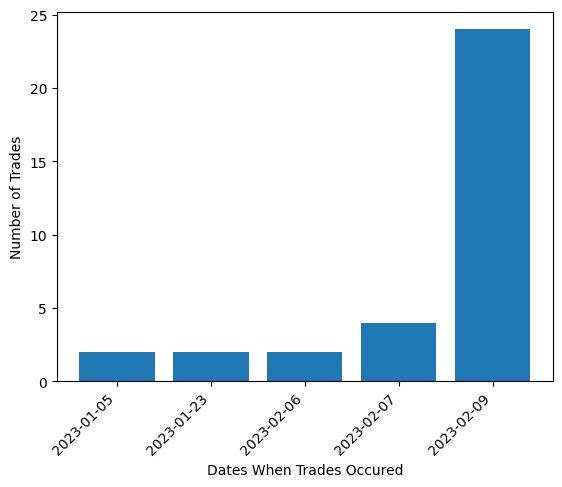

In [130]:

# Your dictionary with keys in the correct format and nested dictionaries
data_dict = converted_dict
# Flatten the nested dictionary to get a list of all values
all_values = [value for nested_dict in data_dict.values() for value in nested_dict.values()]

# Extract dates for each value in the list
dates = [key for key in data_dict.keys() for _ in range(len(data_dict[key]))]

# Flatten the list of lists
flat_values = [item for sublist in all_values for item in sublist]

# Count occurrences of each date
date_counts = Counter(dates)

# Plot the histogram
dates, counts = zip(*date_counts.items())
plt.bar(dates, counts)
plt.xlabel('Dates When Trades Occured')
plt.ylabel('Number of Trades')

plt.xticks(rotation=45, ha='right')
plt.savefig('Trade_Dates.png', bbox_inches='tight')
plt.show()


### Plot for winning percentage before and after trade

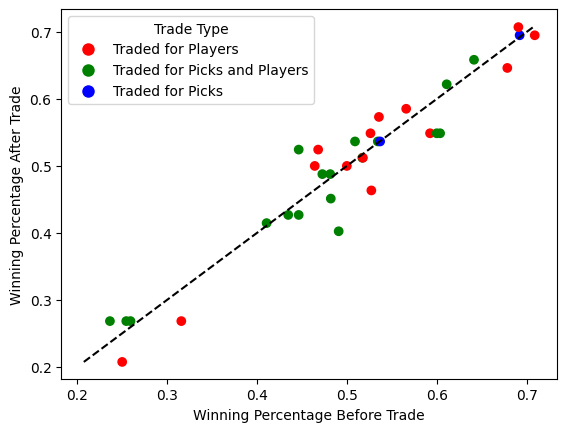

In [131]:
import matplotlib.pyplot as plt

# Assuming percentage is your DataFrame
colors = {'a': 'red', 'b': 'green', 'c': 'blue'}  # Adjust colors as needed

# Plotting
scatter = plt.scatter(percentage['before'], percentage['after'], c=percentage['type'].map(colors))

# Adding labels and legend
plt.xlabel('Winning Percentage Before Trade')
plt.ylabel('Winning Percentage After Trade')

# Creating a custom legend
legend_labels = {
    'a': 'Traded for Players',
    'b': 'Traded for Picks and Players',
    'c': 'Traded for Picks'
}

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10)
                  for label in colors.keys()]

plt.legend(legend_handles, legend_labels.values(), title='Trade Type')

# Adding a diagonal line
min_value = min(percentage['before'].min(), percentage['after'].min())
max_value = max(percentage['before'].max(), percentage['after'].max())
plt.plot([min_value, max_value], [min_value, max_value], 'k--')

# Show the plot

plt.savefig('Win_Perc.png')
plt.show()

### Plot for average point differential before and after trade

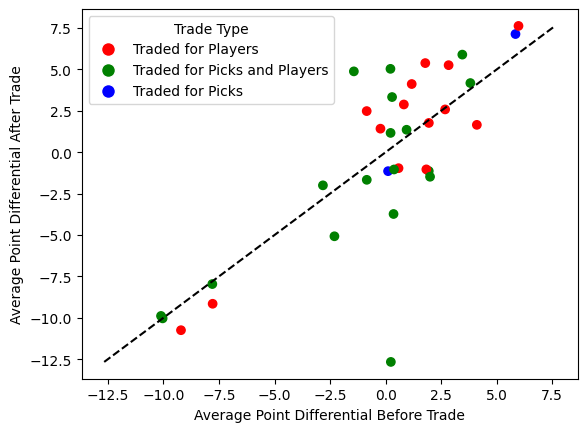

In [132]:
import matplotlib.pyplot as plt

# Assuming percentage is your DataFrame
colors = {'a': 'red', 'b': 'green', 'c': 'blue'}  # Adjust colors as needed

# Plotting
scatter = plt.scatter(data_for_point_diff_plot['before'], data_for_point_diff_plot['after'], c=data_for_point_diff_plot['type'].map(colors))

# Adding labels and legend
plt.xlabel('Average Point Differential Before Trade')
plt.ylabel('Average Point Differential After Trade')

# Creating a custom legend
legend_labels = {
    'a': 'Traded for Players',
    'b': 'Traded for Picks and Players',
    'c': 'Traded for Picks'
}

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10)
                  for label in colors.keys()]

plt.legend(legend_handles, legend_labels.values(), title='Trade Type')

# Adding a diagonal line
min_value = min(data_for_point_diff_plot['before'].min(), data_for_point_diff_plot['after'].min())
max_value = max(data_for_point_diff_plot['before'].max(), data_for_point_diff_plot['after'].max())
plt.plot([min_value, max_value], [min_value, max_value], 'k--')

# Show the plot

plt.savefig('Point_Diff.png')
plt.show()

### Plot for change in winning percentage after trade, based on salary size

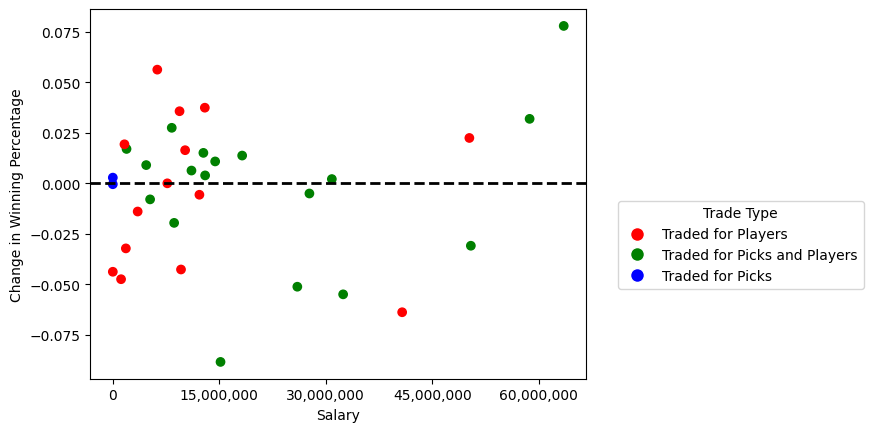

In [133]:
import matplotlib.pyplot as plt

# Assuming percentage is your DataFrame
colors = {'a': 'red', 'b': 'green', 'c': 'blue'}  # Adjust colors as needed

# Plotting
scatter = plt.scatter(percentage['salary'], percentage['delta'], c=percentage['type'].map(colors))

# Adding labels and legend
plt.xlabel('Salary')
plt.ylabel('Change in Winning Percentage')

# Creating a custom legend
legend_labels = {
    'a': 'Traded for Players',
    'b': 'Traded for Picks and Players',
    'c': 'Traded for Picks'
}

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10)
                  for label in colors.keys()]

# Set the legend location outside the plot
legend_location = (1.05, 0.5)

plt.legend(legend_handles, legend_labels.values(), title='Trade Type', bbox_to_anchor=legend_location)


#repalce new axis
end = max(data_for_point_diff_plot['salary']) + 100000

plt.xticks(np.arange(0, end, 15000000)) 
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=2)

# Show the plot
plt.savefig('Sal_Win_Perc.png', bbox_inches='tight')  # Adjusted for saving outside the plot
plt.show()


### Plot for change in point differential after trade, based on salary size   

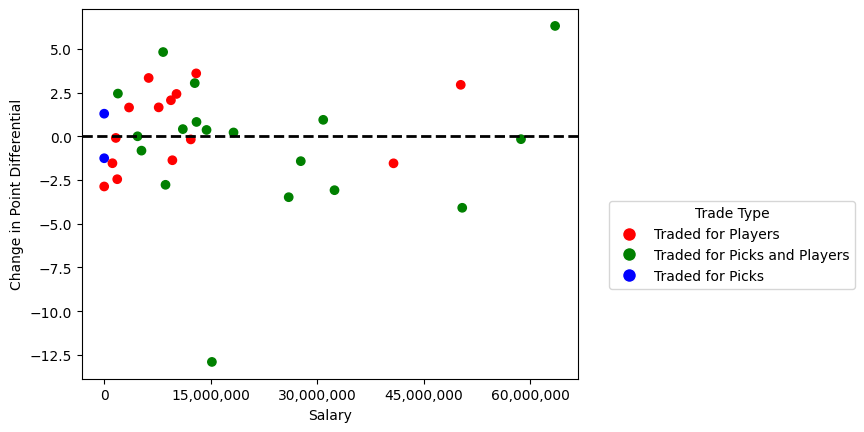

In [134]:
import matplotlib.pyplot as plt

# Assuming percentage is your DataFrame
colors = {'a': 'red', 'b': 'green', 'c': 'blue'}  # Adjust colors as needed

# Plotting
scatter = plt.scatter(data_for_point_diff_plot['salary'], data_for_point_diff_plot['delta'], c=data_for_point_diff_plot['type'].map(colors))

# Adding labels and legend
plt.xlabel('Salary')
plt.ylabel('Change in Point Differential')

# Creating a custom legend
legend_labels = {
    'a': 'Traded for Players',
    'b': 'Traded for Picks and Players',
    'c': 'Traded for Picks'
}

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10)
                  for label in colors.keys()]

plt.legend(legend_handles, legend_labels.values(), title='Trade Type', bbox_to_anchor=legend_location)

legend_location = (1.05, 0.5)

# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=2)

end = max(data_for_point_diff_plot['salary']) + 100000

plt.xticks(np.arange(0, end, 15000000)) 
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Show the plot

plt.savefig('Sal_Point_Diff.png', bbox_inches='tight')
plt.show()